In [48]:
%matplotlib inline

In [49]:
# coding: utf-8


import os
import numpy as np
import pickle as pkl
import argparse
from tqdm import tqdm
from joblib import Parallel, delayed
from copy import copy
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
    
from eval_helpers import top_k_infection_precision_recall
from helpers import load_cascades
from graph_helpers import load_graph_by_name



parser = argparse.ArgumentParser(description='')
parser.add_argument('-g', '--graph', help='graph name')
parser.add_argument('-c', '--cascade_pattern', help='graph name')

# args = parser.parse_args()

# graph_name = args.graph
graph_name = 'grqc'
cascade_pattern = 'grqc'
sampling_method = 'loop_erased'
inf_method = 'order_steiner_tree'
inf_result_dirname = 'outputs/{}/{}/{}'.format(inf_method, graph_name, sampling_method)
query_dirname = 'outputs/queries/{}/{}'.format(graph_name, sampling_method)


g = load_graph_by_name(graph_name)

cascades = load_cascades('cascade/' + cascade_pattern)


methods = ['pagerank', 'random', 'entropy', 'prediction_error']




In [21]:
cascades = load_cascades('cascade/' + cascade_pattern)

scores_by_method = {}
for method in methods:
    scores_by_method[method] = []

c_paths = []  # track the order
for c_path, (obs, c) in tqdm(cascades):
    obs = set(obs)
    c_paths.append(c_path)
    infected = (c >= 0).nonzero()[0]
        
    y_true = np.zeros((len(c), ))
    y_true[infected] = 1
    
    for method in methods:

        cid = os.path.basename(c_path).split('.')[0]
        inf_probas_path = os.path.join(
            inf_result_dirname,
            method,
            '{}.pkl'.format(cid))
        inf_probas_list = pkl.load(open(inf_probas_path, 'rb'))
                
        query_path = os.path.join(
            query_dirname, 
            method, 
            '{}.pkl'.format(cid)
        )
        queries = pkl.load(open(query_path, 'rb'))[0]
        scores = []
        obs_inc = copy(obs)
        for inf_probas, query in zip(inf_probas_list, queries):
            obs_inc.add(query)
            # need to mask out the observations
            mask = np.array([(i not in obs_inc) for i in range(len(c))])

            # score = roc_auc_score(y_true, inf_probas, average=None)
            # score = top_k_infection_precision_recall(g, inf_probas, c, obs, 65)[0]
            score = average_precision_score(y_true[mask], inf_probas[mask])
            scores.append(score)
#            y_pred = (inf_probas > 0.5).nonzero()[0]
#            y_pred
        scores_by_method[method].append(scores)

0it [00:00, ?it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

In [18]:
scores_3d = np.array([scores_by_method[m] for m in methods])

In [19]:
scores_3d.shape # method, rounds, queries

(4, 96, 100)

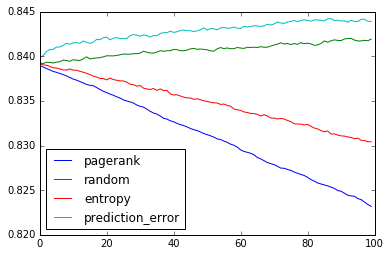

In [20]:
from matplotlib import pyplot as plt

plt.clf()
fig = plt.figure()
for method in methods:
    scores = np.array(scores_by_method[method], dtype=np.float32)
    mean_scores = np.mean(scores, axis=0)
    # print(np.std(scores,axis=0))
    plt.plot(mean_scores)
    plt.hold(True)
plt.legend(methods, loc='best')

In [21]:
fig.savefig('figs/average_precision_score/{}-{}.png'.format(graph_name, sampling_method))

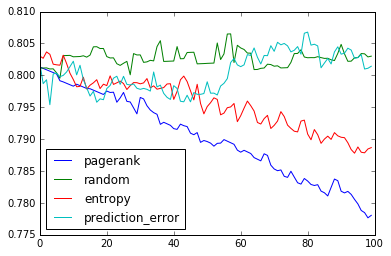

In [22]:
fig = plt.figure()

for scores in scores_3d[:, 0, :]:
    plt.plot(scores)
plt.legend(methods, loc='best')

In [50]:
cascades = load_cascades('cascade/' + cascade_pattern)

scores_by_method = {}
for method in methods:
    scores_by_method[method] = []

c_paths = []  # track the order
for c_path, (obs, c) in tqdm(cascades):
    obs = set(obs)
    c_paths.append(c_path)
    infected = (c >= 0).nonzero()[0]
        
    y_true = np.zeros((len(c), ))
    y_true[infected] = 1
    
    for method in methods:

        cid = os.path.basename(c_path).split('.')[0]
        inf_result_path = os.path.join(
            inf_result_dirname,
            method,
            '{}.pkl'.format(cid))
        inf_nodes_list = pkl.load(open(inf_result_path, 'rb'))
                
        query_path = os.path.join(
            query_dirname, 
            method, 
            '{}.pkl'.format(cid)
        )
        queries = pkl.load(open(query_path, 'rb'))[0]
        scores = []
        obs_inc = copy(obs)
        for inf_nodes, query in zip(inf_nodes_list, queries):
            obs_inc.add(query)
            # need to mask out the observations
            inf_nodes_flag = np.zeros(len(c))
            inf_nodes_flag[list(inf_nodes)] = 1

            score = precision_recall_fscore_support(y_true[mask], inf_nodes_flag[mask], average='binary')
            # score = average_precision_score(y_true[mask], inf_nodes_flag[mask])
            scores.append(score)
#            y_pred = (inf_probas > 0.5).nonzero()[0]
#            y_pred
        scores_by_method[method].append(scores)

96it [00:59,  1.84it/s]


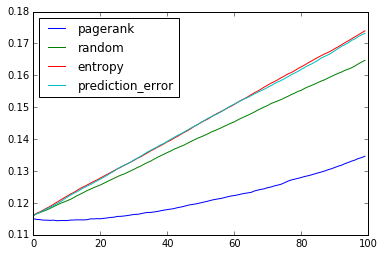

In [53]:
from matplotlib import pyplot as plt
idx = 2
plt.clf()
fig = plt.figure()
for method in methods:
    data = [[row[idx] for row in run] for run in scores_by_method[method] if len(run) == 100]
    scores = np.array(data, dtype=np.float32)
    mean_scores = np.mean(scores, axis=0)
    # print(np.std(scores,axis=0))
    plt.plot(mean_scores)
    plt.hold(True)
plt.legend(methods, loc='best')